In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import numpy as np

In [2]:
plt.rcParams["figure.figsize"]=[15,5]

In [3]:
#Load SP current data and plot
raw_sp = pd.read_csv('sp_jan.csv', usecols =['timestamp', 'data.A1'])
#only one phase for sp

# mins=90
# test_sp=raw_sp.head(60*mins)
# test_sp.index=test_sp['timestamp']
# test_sp.to_csv('sp_head.csv', index=False)
# test_sp

In [4]:
# %matplotlib notebook
# test_sp=pd.read_csv('sp_head.csv')
test_sp=raw_sp
# test_sp.plot(x='timestamp', y='data.A1')
# plt.margins(0)

In [5]:
#Load LD data and plot

raw_ld=pd.read_csv('loader_jan.csv', usecols=['timestamp', 'data.ax', 'data.ay', 'data.az'])

raw_ld["acc"] = ( raw_ld["data.ax"]**2 + raw_ld["data.az"]**2 ) ** 0.5

# window = mins * 60 * 100

acc=raw_ld[["timestamp", "acc"]]
acc.set_index('timestamp')

# test_ld.plot()
# test_ld['timestamp']=acc.head(window)['timestamp']
test_ld=acc
test_ld['acc']=pd.Series.to_frame(test_ld.acc.rolling(75, center=True).std())

/home/raghu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [6]:
# test_ld=pd.read_csv('loader14.csv')

In [7]:
# test_ld.plot(x='timestamp', y='acc')
# plt.margins(0)

In [8]:
# test_ld.plot(x='timestamp', y='acc', color='r')
# test_sp.plot(x='timestamp', y='data.A1')

In [9]:
timethresh=20
sptimethresh=20

In [10]:
#Get boards from Screenprinter
# %matplotlib
test_sp=test_sp[['data.A1','timestamp']]
events=scipy.signal.find_peaks(test_sp['data.A1'], height=(2.22), distance=sptimethresh, width=1)
test_sp.insert(2,'state_new',0)
sampleno=0
for x in events[0]:
    if test_sp.at[x, 'data.A1'] < 5:
        test_sp.at[x, 'state_new'] = 1
    elif test_sp.at[x, 'data.A1'] > 9:
        test_sp.at[x, 'state_new'] = 2
# print('Boards detected in SP:',len(test_sp.query('state == 1'))-1)
detect_sp=test_sp[test_sp['state_new'] == 1]
# plt.stem(detect_sp.index, detect_sp['state_new'])

In [11]:
# sp_boards.shape[0]

In [12]:
import datetime as dt
import time
import matplotlib.dates as mdates

pattern="%Y-%m-%dT%H:%M:%S.%f"
detect_sp=test_sp[test_sp['state_new'] == 1]
test_sp['timestamp'] =  pd.to_datetime(test_sp['timestamp'], format=pattern)
detect_sp['timestamp'] =  pd.to_datetime(detect_sp['timestamp'], format=pattern)
detect_sp.head()

/home/raghu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/raghu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,data.A1,timestamp,state_new
29066,2.46,2019-01-02 05:11:42.316191,1
29142,2.43,2019-01-02 05:13:22.319302,1
29453,2.43,2019-01-02 05:20:13.401158,1
29474,3.43,2019-01-02 05:20:41.111115,1
29510,3.01,2019-01-02 05:21:28.696098,1


In [13]:
detect_sp=detect_sp.diff(1)
test_sp.insert(2,'state',0)
detect_sp=detect_sp[["timestamp"]].applymap(lambda x: x.seconds)
# lastkey=detect_sp.index.tolist()[0]

# for x in detect_sp.index.tolist():
#     if detect_sp.ix[x, 'timestamp'] > sptimethresh:
#         test_sp.at[x, 'state']=0
#         test_sp.at[lastkey, 'state']=1
#     else:
#         test_sp.at[x, 'state']=0
#         lastkey=x

# for x in detect_sp.index.tolist():
#     if detect_sp.ix[x, 'timestamp'] > sptimethresh:
#         test_sp.at[x, 'state']=1
#     else:
#         test_sp.at[x, 'state']=0
#     lastkey=x
sp_boards=test_sp[test_sp['state'] == 1]
# print('Boards detected in SP:', len(sp_boards))

In [14]:
# sp_boards=test_sp[(test_sp['state_new'] == 1)]
print('Boards detected in SP:', sp_boards.shape[0])

Boards detected in SP: 153


In [15]:
#Get boards from Loader
board=scipy.signal.find_peaks(test_ld.acc,height=(0.016), width=1)
boards=[]
differ=np.diff(board[0])
differ=differ.tolist()
# test_ld.insert(2,'state',0)
boards=[]
boards.append(board[0][0])
sumdiffer=0
for i, x in enumerate(board[0]):
    try:
        sumdiffer+=differ[i]
        if sumdiffer>timethresh*100:
            boards.append(board[0][i])
            test_ld.at[x, 'state']=1
            sumdiffer=0
        if differ[i] < timethresh*100:
            test_ld.at[x, 'state']=2
    except:
        continue
print('Boards detected in LD:', len(boards))
ld_boards=test_ld[test_ld['state']==1]

/home/raghu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/raghu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Boards detected in LD: 194


In [16]:
test_ld['timestamp'] =  pd.to_datetime(test_ld['timestamp'], format=pattern)
ld_boards['timestamp'] =  pd.to_datetime(ld_boards['timestamp'], format=pattern)

/home/raghu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/raghu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5, 1.0, 'Board Detections')

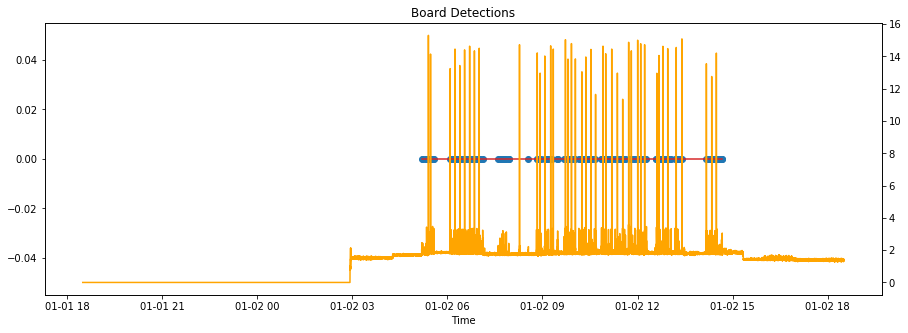

In [17]:
# %matplotlib notebook
fig, ax1 = plt.subplots()

ax1.stem(sp_boards['timestamp'], sp_boards['state'], 'red')

# ax1.xaxis.set_major_locator(mdates.DateFormatter('%H:%M'))

ax1.set_xlabel('Time')

ax2 = ax1.twinx()

ax2.plot(test_sp['timestamp'], test_sp['data.A1'], 'orange')

plt.title('Board Detections')

In [18]:
# %matplotlib  notebook
# fig, ax1 = plt.subplots()

# ax1.stem(ld_boards['timestamp'], ld_boards['state'], 'orange')

# ax1.xaxis.set_major_locator(mdates.DateFormatter('%H:%M'))

# ax1.set_xlabel('Time')

# ax2 = ax1.twinx()

# ax2.plot(test_ld['timestamp'], test_ld['acc'], 'blue')

# plt.title('Board Detections')

In [19]:
# %matplotlib notebook
# fig, ax1 = plt.subplots()

# ax1.stem(ld_boards['timestamp'], ld_boards['state'], 'green')

# # ax1.xaxis.set_major_locator(mdates.DateFormatter('%H:%M'))

# ax1.set_xlabel('Time')

# ax2 = ax1.twinx()

# ax2.stem(sp_boards['timestamp'], sp_boards['state'], 'red')

# plt.title('Board Detections')

In [20]:
%matplotlib tk
fig, ax1 = plt.subplots()

ax1.plot(test_ld['timestamp'], -1*test_ld['acc'], 'blue')
ax1.stem(ld_boards['timestamp'], -0.4*ld_boards['state'], 'green', '.')
ax1.set_xlabel('Time')

ax2 = ax1.twinx()

ax2.plot(test_sp['timestamp'], test_sp['data.A1'], 'orange')
ax2.stem(sp_boards['timestamp'], 10*sp_boards['state'], 'red', '.')
ax2.stem(sp_boards['timestamp'], 5*sp_boards['state_new'], 'purple', '.')
plt.title('Board Detections')

Text(0.5, 1.0, 'Board Detections')

In [21]:
# imt=[]
# ldLists=ld_boards.timestamp.unique()
# ldLists=
# spLists=sp_boards.timestamp.unique()
# for x in ldLists:
#     for y in spLists:
#         if y>x:
#             imt=y-x
#             print(imt.dtype)

In [22]:
# clean=test_ld[(test_ld['timestamp'] >= '2018-03-17 02:17:00') & (test_ld['timestamp'] < '2018-03-17 05:17:00')]
# test_ld.to_csv('LD14clean.csv', index=False)
# clean=test_sp[(test_sp['timestamp'] >= '2018-03-17 02:17:00') & (test_sp['timestamp'] < '2018-03-17 05:17:00')]
# test_sp.to_csv('SP14clean.csv', index=False)

In [23]:
# board_mapping=pd.DataFrame(columns=['BoardID','LD_Time','SP_Time'])
# board_mapping

In [24]:
matching_list=[]
spmatch=0
posdiff=0
for ldindex, ldrow in ld_boards.iterrows():
#     print (index, row["timestamp"], row["state"])
    ldts=ldrow['timestamp']
#     print(ldts)
    bestdiff=-1
    for spindex, sprow in sp_boards.iterrows():
        spts=sprow['timestamp']
        posdiff=abs(spts-ldts)                  #Time difference between loader detection 
        if bestdiff==-1:                         #and screenprinter detection
            bestdiff=posdiff
        elif posdiff<bestdiff:
            bestdiff=posdiff
            spmatch=sprow['timestamp']
        elif posdiff>bestdiff:
#             print(bestdiff.seconds)
            if (bestdiff.seconds >50) or (bestdiff.seconds <0): #If the best difference is more than 19secs,
                spmatch='No match'                              #Tag as match not found
            break

    try:
        spmatch=spmatch.strftime(pattern)
    except:
        continue
    matchrow={"BoardID":ldts.strftime(pattern), "LD_Time": ldts.strftime(pattern), "SP_Time": spmatch}
    matching_list.append(matchrow)

In [25]:
board_mapping=pd.DataFrame(matching_list)
board_mapping.head()

,BoardID,LD_Time,SP_Time
0,2019-01-02T05:19:23.870431,2019-01-02T05:19:23.870431,2019-01-02T05:20:13.401158
1,2019-01-02T05:20:34.714097,2019-01-02T05:20:34.714097,2019-01-02T05:20:41.111115
2,2019-01-02T05:21:52.862465,2019-01-02T05:21:52.862465,2019-01-02T05:21:28.696098
3,2019-01-02T05:23:47.670511,2019-01-02T05:23:47.670511,2019-01-02T05:24:37.703624
4,2019-01-02T05:24:59.849745,2019-01-02T05:24:59.849745,2019-01-02T05:24:37.703624


In [26]:
ldt=pd.to_datetime(board_mapping["LD_Time"])
spt=pd.to_datetime(board_mapping["SP_Time"])

In [27]:
ldt=ldt.apply (lambda x: x.to_pydatetime().timestamp())
spt=spt.apply (lambda x: x.to_pydatetime().timestamp())

In [29]:
sns.distplot(diff,bins=100)

NameError: name 'sns' is not defined

In [ ]:
sns.distplot(diff[diff.between(-5,10)],bins=100)

In [ ]:
diff.plot.hist(bins=100)

In [ ]:
diff[diff.between(-5,10)].plot.hist(bins=100)